In [2]:
import pandas as pd
import pickle 
import numpy as np
import networkx as nx
import re
from collections import Counter
import plotly.express as px

ROOT_PATH = '/home/chiwon/workspace/vmh_workbook/mangoflavoured.github.io'
graphs = ["Colorectal", "IBD", "Obesity", "T2D", "WT2D"] #Cirrhosis: error|

In [4]:
with open(f"{ROOT_PATH}/data/mm-graph/preprocessed_T2D.pkl", "rb") as h:
    t2d_dict = pickle.load(h)
    print(t2d_dict.keys())

dict_keys(['abundance_profile', 'marker_profile', 'microbe_names', 'fold_idx_1', 'fold_idx_2', 'fold_idx_3', 'fold_idx_4', 'fold_idx_5'])


In [5]:
for key in t2d_dict.keys():
    print(type(t2d_dict[key]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'list'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>


In [6]:
t2d_abundance = pd.DataFrame(t2d_dict["abundance_profile"])
t2d_marker = pd.DataFrame(t2d_dict["marker_profile"])
t2d_abundance.to_csv(f"{ROOT_PATH}/data/mm-graph/T2D_Abundance_Profile.csv")
t2d_marker.to_csv(f"{ROOT_PATH}/data/mm-graph/T2D_Marker_Profile.csv")

In [7]:
t2d_marker.shape

(344, 120001)

In [8]:
t2d_marker.head()

dataset_name,ID@subjectID,CLI@bodysite,Y@disease,CLI@age,CLI@gender,CLI@country,CLI@sequencing_technology,CLI@pubmedid,CLI@camp,CLI@paired_end_insert_size,...,X@gi|83286007|ref|XM_724880.1|,X@gi|83591340|ref|NC_007643.1|:3854287-3855165,X@gi|83956146|ref|NZ_AALZ01000014.1|:c71868-71287,X@gi|84389706|ref|NZ_AAMR01000024.1|:c62016-61705,X@gi|85057280|ref|NC_007716.1|:178414-178599,X@gi|85057280|ref|NC_007716.1|:195234-195935,X@gi|88607955|ref|NC_007798.1|:118090-119082,X@gi|88797415|ref|NZ_AAOE01000002.1|:c235147-234506,X@gi|89892746|ref|NC_007907.1|:c3938880-3937900,X@gi|94502223|ref|NZ_AANL01000001.1|:c8848-8444
ID@sampleID,,,,,,,,,,,,,,,,,,,,,
CON-001,con-001,stool,n,21,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-002,con-002,stool,n,53,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-003,con-003,stool,n,61,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-004,con-004,stool,n,55,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-005,con-005,stool,n,53,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0


In [70]:
#Microbe strain count
match = "X@gi"
c = 0
for column in t2d_marker.columns:
    if re.match(match, column):
        c += 1
    else:
        continue
print(f"NUMBER OF MICROBE STRAINS: {c}")

NUMBER OF MICROBE STRAINS: 119792


In [10]:
#Sequencing tech tyoes
sequencing_tech = t2d_marker["CLI@sequencing_technology"].unique().tolist()
for tech in sequencing_tech:
    print(tech)

Illumina


In [11]:
#gender distribution
gender = t2d_marker["CLI@gender"].tolist()
c = Counter(gender)
print(c)

Counter({'male': 190, 'female': 154})


In [12]:
#checking duplicates
column_list = list(t2d_marker.columns)
column_set = set(column_list)
if len(list(column_set)) == len(column_list):
    print("NO DUPLICATES")
else:
    print("DUPLICATES DETECTED")

NO DUPLICATES


In [13]:
#overall sparsity of microbes
t2d_marker_microbes = t2d_marker.filter(regex = "^X@gi")
t2d_marker_microbes = t2d_marker_microbes.astype(int)
t2d_matrix = t2d_marker_microbes.to_numpy()
print("SPARSITY: {}".format((t2d_matrix ==0).mean()))

SPARSITY: 0.8880357251018044


In [14]:
#label counts
label_count = len(t2d_marker)
label_false = t2d_marker.loc[t2d_marker["Y@disease"] == "n"]
false_count = len(label_false)
true_count = label_count - false_count

print(f"TOTAL: {label_count}\nTRUE_NEG: {false_count}\nTRUE_POS: {true_count}")

TOTAL: 344
TRUE_NEG: 174
TRUE_POS: 170


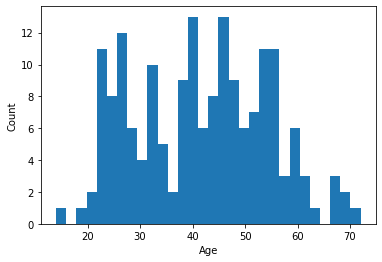

In [27]:
#age distribution
import matplotlib.pyplot as plt
#label split
t2d_marker_false = t2d_marker.loc[t2d_marker["Y@disease"] == "n"] #false as in normal
t2d_false_matrix = t2d_marker_false.filter(regex = "^X@gi").astype(int).to_numpy()
t2d_marker_true = t2d_marker.loc[t2d_marker["Y@disease"] == "t2d"] #true as in has diabetes
t2d_true_matrix = t2d_marker_true.filter(regex = "^X@gi").astype(int).to_numpy()

wt_age = t2d_marker_false["CLI@age"].astype(int).tolist()
disease_age = t2d_marker_true["CLI@age"].astype(int).tolist()

plt.hist(wt_age, 30)
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

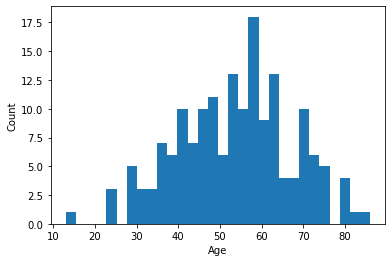

In [28]:
plt.hist(disease_age, 30)
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

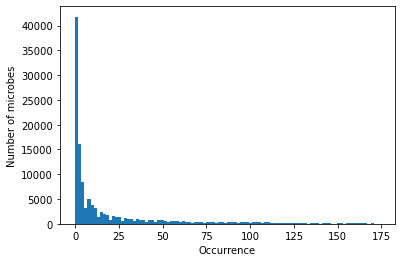

In [31]:
#bacteria abundance distribution
bacteria_count = np.count_nonzero(t2d_false_matrix, axis=0)
plt.hist(bacteria_count, 100)
plt.xlabel("Occurrence")
plt.ylabel("Number of microbes")
plt.show()

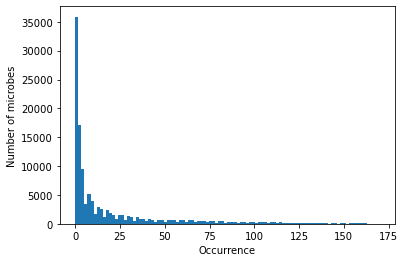

In [32]:
#bacteria abundance distribution
bacteria_count_t2d = np.count_nonzero(t2d_true_matrix, axis=0)
plt.hist(bacteria_count_t2d, 100)
plt.xlabel("Occurrence")
plt.ylabel("Number of microbes")
plt.show()

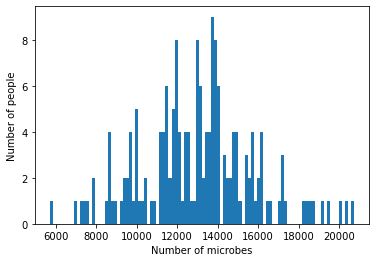

In [33]:
#Distribution of no. of bacteria in people
bacteria_per_person = np.count_nonzero(t2d_false_matrix, axis=1)
plt.hist(bacteria_per_person, 100)
plt.xlabel("Number of microbes")
plt.ylabel("Number of people")
plt.show()

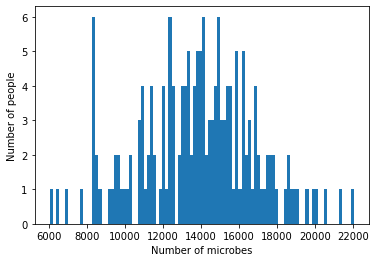

In [34]:
bacteria_per_person = np.count_nonzero(t2d_true_matrix, axis=1)
plt.hist(bacteria_per_person, 100)
plt.xlabel("Number of microbes")
plt.ylabel("Number of people")
plt.show()

In [45]:
#Microbes exclusively present on WT/Patients
#Check if there are such microbes 
matrix_list = [t2d_matrix, t2d_false_matrix, t2d_true_matrix]
for mat in matrix_list:
    print((~mat.any(axis=0)).any())

False
True
True


In [75]:
true_exclusive_microbe_idx = np.where(~t2d_false_matrix.any(axis=0))[0].tolist()
false_exclusive_microbe_idx = np.where(~t2d_true_matrix.any(axis=0))[0].tolist()

microbes_list = t2d_marker_microbes.columns.tolist()
true_exclusive_strains = []
false_exclusive_strains = []

for i in true_exclusive_microbe_idx:
    true_exclusive_strains.append(microbes_list[i])
print("NUM OF TRUE EXCLUISIVE MICROBE STRAINS: {}".format(len(true_exclusive_microbes)))
    
for i in false_exclusive_microbe_idx:
    false_exclusive_strains.append(microbes_list[i])
print("NUM OF FALSE EXCLUISIVE MICROBE STRAINS: {}".format(len(true_exclusive_microbes)))
    
#check if there's overlap
a = set(true_exclusive_strains)
b = set(false_exclusive_strains)
if not a&b: print("NO OVERLAP")

NUM OF TRUE EXCLUISIVE MICROBE STRAINS: 19531
NUM OF FALSE EXCLUISIVE MICROBE STRAINS: 19531
NO OVERLAP


In [76]:
for i in range(10):
    print(true_exclusive_strains[i])
print("----------------------------------------------")
for i in range(10):
    print(false_exclusive_strains[i])

X@gi|108562424|ref|NC_008086.1|:1297524-1298312
X@gi|119025018|ref|NC_008618.1|:c1768547-1766292
X@gi|120601051|ref|NC_008751.1|:3012106-3012942
X@gi|139437954|ref|NZ_AAVN02000002.1|:c102952-102281
X@gi|145297124|ref|NC_009348.1|:c3777316-3776609
X@gi|146386150|ref|NZ_AAXG02000001.1|:c44509-44321
X@gi|146386227|ref|NZ_AAYG02000011.1|:139434-139553
X@gi|146386227|ref|NZ_AAYG02000011.1|:139743-139856
X@gi|150006674|ref|NC_009615.1|:c3911175-3910225
X@gi|153883811|ref|NZ_ABDX01000024.1|:9104-9868
----------------------------------------------
X@gi|116626972|ref|NC_008532.1|:867149-868246
X@gi|119025018|ref|NC_008618.1|:1718316-1718732
X@gi|139437954|ref|NZ_AAVN02000002.1|:c333891-333082
X@gi|139439345|ref|NZ_AAVN02000008.1|:97016-97243
X@gi|139439895|ref|NZ_AAVN02000014.1|:3095-3211
X@gi|139439942|ref|NZ_AAVN02000015.1|:24369-25103
X@gi|139440029|ref|NZ_AAVN02000017.1|:7510-8175
X@gi|139440029|ref|NZ_AAVN02000017.1|:c5757-5104
X@gi|139440029|ref|NZ_AAVN02000017.1|:c9199-9107
X@gi|14638622

In [87]:
strain_split_list = [true_exclusive_strains, false_exclusive_strains]
microbe_id_set_list = []

for strain in strain_split_list:
    microbe_id_list_sub = []
    for strain in t2d_marker_microbes.columns:
        uniprot_id = strain.split("|")[3]
        microbe_id_list_sub.append(uniprot_id)
    microbe_id_list_sub = set(microbe_id_list_sub)
    microbe_id_set_list.append(microbe_id_list_sub)
    
true

In [35]:
#"Useless" columns
cli_features = t2d_marker.filter(regex = "^CLI@")
print("NUMBER OF CLIENT FEATURES: {}".format(len(cli_features.columns.tolist())))
onecount = 0
useless_columns = []
for col in cli_features.columns:
    if (len(cli_features[col].unique()) == 1):
        #print(cli_features[col].unique())
        onecount +=1
        useless_columns.append(col)

print("FEATURES WITH ONLY ONE VALUE:", onecount)
#for col in useless_columns:
#    print(col)

NUMBER OF CLIENT FEATURES: 207
FEATURES WITH ONLY ONE VALUE: 190


------------------------------ABUNDANCE DATAFRAME---------------------------------------------

In [88]:
t2d_abundance.head()

dataset_name,ID@subjectID,CLI@bodysite,Y@disease,CLI@age,CLI@gender,CLI@country,CLI@sequencing_technology,CLI@pubmedid,CLI@camp,CLI@paired_end_insert_size,...,X@k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas|s__Halomonas_boliviensis,X@k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_kanaloae,X@k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_axonopodis,X@k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_fuscans,X@k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_bovis,X@k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia|s__Zunongwangia_profunda,X@k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pallens,X@k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae|g__Rhodopirellula|s__Rhodopirellula_unclassified,X@k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii,Y@label
ID@sampleID,,,,,,,,,,,,,,,,,,,,,
CON-001,con-001,stool,n,21,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-002,con-002,stool,n,53,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-003,con-003,stool,n,61,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-004,con-004,stool,n,55,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0
CON-005,con-005,stool,n,53,female,china,Illumina,23023125,nd,nd,...,0,0,0,0,0,0,0,0,0,0


In [166]:
t2d_abundance_false = t2d_abundance.loc[t2d_abundance["Y@disease"] == "n"]
print(len(t2d_abundance_false))
t2d_abundance_true = t2d_abundance.loc[t2d_abundance["Y@disease"] == "t2d"]
print(len(t2d_abundance_true))

t2d_neg_abundance_microbes = t2d_abundance_false.filter(regex = "^X@").astype(float)
t2d_pos_abundance_microbes = t2d_abundance_true.filter(regex = "^X@").astype(float)

174
170


In [96]:
#marginal sum
neg_sum = t2d_neg_abundance_microbes.sum(axis=1)
print(neg_sum)
pos_sum = t2d_pos_abundance_microbes.sum(axis=1)
print(pos_sum)

ID@sampleID
CON-001     99.99997
CON-002     99.99996
CON-003    100.00001
CON-004     99.99995
CON-005     99.99997
             ...    
NOM018      99.99996
NOM022     100.00007
NOM023     100.00003
NOM026      99.99997
NOM029     100.00001
Length: 174, dtype: float64
ID@sampleID
DLF009    100.00002
DLF012     99.99999
DLF013     99.99996
DLF014     99.99999
DLM001    100.00001
            ...    
DOM020     99.99996
DOM021     99.99997
DOM023     99.99999
DOM024    100.00001
DOM025     99.99999
Length: 170, dtype: float64


In [153]:
#entropy
from scipy.stats import entropy
entropy_list = [] #[[neg_ent], [pos_ent]]

for dataframe in [t2d_neg_abundance_microbes, t2d_pos_abundance_microbes]:
    entropy_sublist = []
    for idx, row in dataframe.iterrows():
        row_ent = entropy(row)/np.log(572) #scaling
        entropy_sublist.append(row_ent)
    entropy_list.append(entropy_sublist)

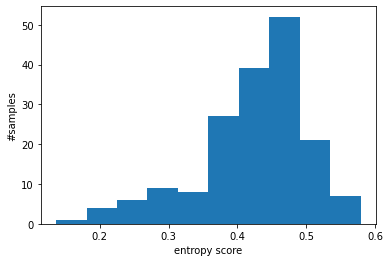

DIABETES NEGATIVE MEAN ENTROPY SCORE: 0.42218128196894755


In [162]:
plt.hist(entropy_list[0], 10)
plt.xlabel("entropy score")
plt.ylabel("#samples")
plt.show()
print("DIABETES NEGATIVE MEAN ENTROPY SCORE: {}".format(np.mean(entropy_list[0])))

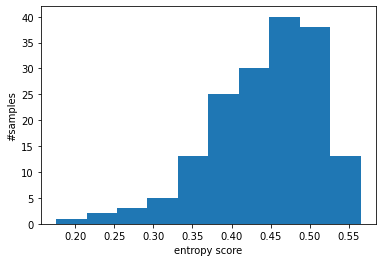

DIABETES POSITIVE MEAN ENTROPY SCORE: 0.4429164178569426


In [163]:
plt.hist(entropy_list[1], 10)
plt.xlabel("entropy score")
plt.ylabel("#samples")
plt.show()
print("DIABETES POSITIVE MEAN ENTROPY SCORE: {}".format(np.mean(entropy_list[1])))

In [179]:
def entropy_calculator(df):
    label_neg = df.loc[df["Y@label"] == 0].filter(regex = "^X@")
    label_pos = df.loc[df["Y@label"] == 1].filter(regex = "^X@")
    
    entropy_list = [] #[[neg_ent], [pos_ent]]

    for dataframe in [label_neg, label_pos]:
        entropy_sublist = []
        for idx, row in dataframe.iterrows():
            row_ent = entropy(row)/np.log(len(label_neg.columns.tolist())) #scaling
            entropy_sublist.append(row_ent)
        entropy_list.append(entropy_sublist)
    
    return entropy_list

col_abundance = pd.read_csv(f"{ROOT_PATH}/data/mm-graph/Colorectal_Abundance_Profile.csv")
col_ent = entropy_calculator(col_abundance)

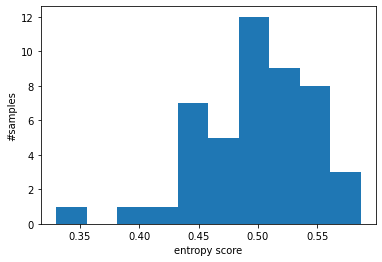

COLORECTAL CANCER NEGATIVE MEAN ENTROPY SCORE: 0.498951569370593


In [180]:
plt.hist(col_ent[0], 10)
plt.xlabel("entropy score")
plt.ylabel("#samples")
plt.show()
print("COLORECTAL CANCER NEGATIVE MEAN ENTROPY SCORE: {}".format(np.mean(col_ent[0])))

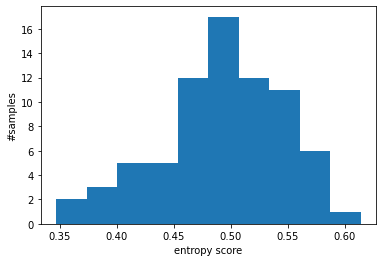

COLORECTAL CANCER NEGATIVE MEAN ENTROPY SCORE: 0.49063941591572


In [181]:
plt.hist(col_ent[1], 10)
plt.xlabel("entropy score")
plt.ylabel("#samples")
plt.show()
print("COLORECTAL CANCER NEGATIVE MEAN ENTROPY SCORE: {}".format(np.mean(col_ent[1])))